In [1]:
import os
import sys
from pathlib import Path

CWD = [p for p in Path().resolve().parents if p.stem == "eco-nsr"][0]
sys.path.append(CWD.as_posix())
sys.path.append(os.path.join(CWD, "src", "representation", "PyTorch_VAE"))

In [2]:
from typing import OrderedDict, Union

import numpy as np
import torch
from yacs.config import CfgNode
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, Resize

from src.data.RavenMatrices import RavenMatrices
from src.representation.PyTorch_VAE.models import *  # noqa: F403

In [3]:
def show_image(img: np.ndarray) -> None:
    """
    Recieve numpy array of shape [channels, height, width] and display it using pyplot
    """
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis("off")
    plt.show()


def crop_img(img: np.ndarray, bbox: list[float]) -> np.ndarray:
    """
    Use bbox to crop an image to a single panel.

    Parameters
    ----------
    img : np.ndarray
        Panel image of shape [channels, height, width]
    bbox : list[float]
        Shape bounding box
    """
    return img[:, int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])]


def sample_z(mu : torch.Tensor, logvar : torch.Tensor) -> torch.Tensor:
    """
    Sample from a Gaussian distribution defined by mu and logvar.

    Parameters
    ----------
    mu : torch.Tensor
        Mean of the Gaussian distribution.
    logvar : torch.Tensor
        Log variance of the Gaussian distribution.
    
    Returns
    -------
    torch.Tensor
        Sampled tensor from the Gaussian distribution.
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [4]:
with open(os.path.join(CWD, "global_cfg.yml"), "r") as f:
    global_cfg = CfgNode.load_cfg(f)

In [5]:
model = vae_models[global_cfg.REPRESENTATION.MODEL.name](  # noqa: F405
    hidden_dims=[32] * int(np.log2(global_cfg.REPRESENTATION.TRAINING.patch_size / 4)),
    **global_cfg.REPRESENTATION.MODEL,
)

checkpoint = torch.load(
    os.path.join(
        CWD,
        global_cfg.REPRESENTATION.TRAINING.output,
        global_cfg.REPRESENTATION.MODEL.name,
        "version_0",
        "checkpoints",
        "last.ckpt",
    ),
    weights_only=True,
)

model_state_dict = OrderedDict()
for key in checkpoint["state_dict"].keys():
    if key.startswith("model."):
        model_state_dict[key[6:]] = checkpoint["state_dict"][key]
    else:
        model_state_dict[key] = checkpoint["state_dict"][key]

model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [6]:
ds = RavenMatrices(
    os.path.join(global_cfg.DATA.path, "RAVEN-F"),
    os.path.join(CWD, global_cfg.DATA.RavenMatrices.dataset_file),
    transform=Compose([
        ToTensor(),
    ]),
)

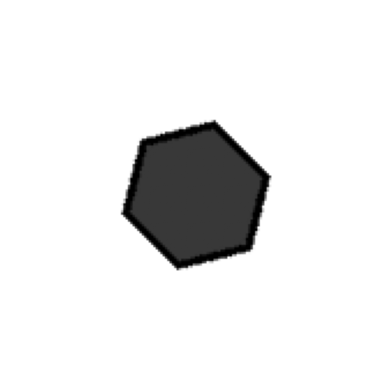

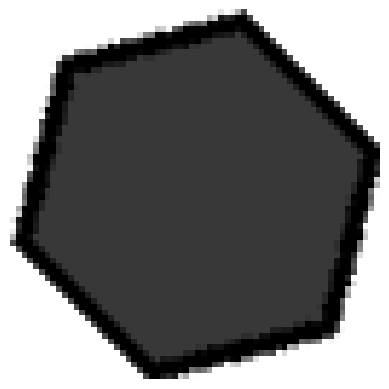

In [7]:
sample = ds[0]
show_image(sample[0]["img"])
show_image(crop_img(sample[0]["img"], sample[0]["locs"][0]))

In [8]:
shape = crop_img(sample[0]["img"], sample[0]["locs"][0])
shape = Resize((
    global_cfg.REPRESENTATION.TRAINING.patch_size,
    global_cfg.REPRESENTATION.TRAINING.patch_size,
))(shape)

shape = shape.to("cuda:0")
model = model.to("cuda:0")

with torch.no_grad():
    mu, logvar = model.encode(shape.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02777744..1.0].


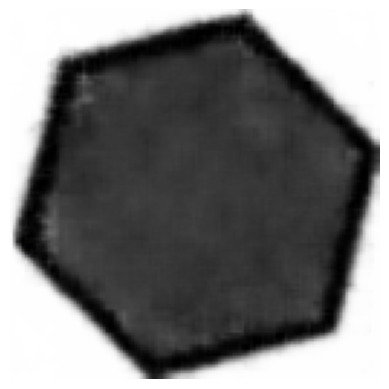

In [9]:
z = sample_z(mu, logvar)

with torch.no_grad():
    recon = model.decode(z)

show_image(recon.squeeze(0).cpu())

In [10]:
tnsr : torch.Tensor = torch.tensor(0)
for s in sample:
    img = s['img']
    for box in s['locs']:
        cropped_img = crop_img(img, box)
        resized_img = Resize((
            global_cfg.REPRESENTATION.TRAINING.patch_size,
            global_cfg.REPRESENTATION.TRAINING.patch_size,
        ))(cropped_img)
        tnsr = resized_img.unsqueeze(0) if tnsr.dim() == 0 else torch.cat((tnsr, resized_img.unsqueeze(0)), dim=0)

tnsr = tnsr.to("cuda:0")

In [16]:
with torch.no_grad():
    mu, logvar = model.encode(tnsr)
    z = sample_z(mu, logvar)

In [17]:
z.to("cpu")

tensor([[ 0.6275,  1.4798, -0.2660,  0.7547,  0.5112,  1.0990],
        [ 0.2528,  0.9633,  1.4545,  3.0777,  1.4192,  0.2161],
        [-1.2912,  1.8811, -0.4863,  1.5658,  1.7480,  0.2695],
        [ 0.1910,  1.7451, -1.1911, -0.8564,  0.5185,  0.2910],
        [-0.1633,  1.8059, -1.4666,  1.6123,  1.7795,  0.5043],
        [ 1.2958,  2.8411,  0.0497,  0.4542,  1.5572, -0.3408],
        [-0.2251,  1.0877,  1.9305,  0.4043, -0.0077,  0.5526],
        [ 0.8731,  1.5424,  0.1352,  0.4276,  0.9688, -0.1855],
        [-0.1975,  2.5257,  2.4425,  0.4350,  0.0811,  0.4735],
        [-0.1997,  2.0860,  2.2295,  0.4458, -0.0092,  0.5191],
        [ 0.9703,  1.5394,  0.0690,  0.4526,  0.9185, -0.2001],
        [ 0.1417,  1.8090, -1.2134, -0.5951,  0.1933, -0.1230],
        [ 0.1282,  2.1854, -1.3955, -0.6030,  0.1703, -0.2049],
        [ 0.1231,  1.4621, -0.9829, -0.6337,  0.2171, -0.1195],
        [ 0.1448,  1.9514, -1.3159, -0.5820,  0.1853, -0.1567],
        [ 0.8941,  1.5358,  0.0968,  0.4